In [1]:
text_file = 'hongloumeng.txt'
char_to_remove = r'[0-9a-zA-Z]'

import re
import numpy 
import torch
import collections
print('Is gpu available?,' torch.cuda.is_available())

with open(text_file,encoding='utf-8') as f:
    txt = f.read()
print(txt[:50])
cleantxt = re.sub(r'[0-9a-zA-Z]','',txt)

vocab=list(set(cleantxt))
vocab_size=len(vocab)
print('document is', len(cleantxt),'characters long.')
print('There are', vocab_size, 'characters')
print('The most common characters are')
print(collections.Counter(cleantxt).most_common(20))
char2idx = {vocab[i]:i for i in range(vocab_size)}
idx2char = {i:vocab[i] for i in range(vocab_size)}
encode = lambda s:[char2idx[c] for c in s]
decode = lambda s:''.join([idx2char[i] for i in s])
sample = "甄士隐梦幻识通灵　贾雨村风尘怀闺秀"
print("ecoded text", encode(sample))
print("decode encoded text", decode(encode(sample)))

data = torch.tensor(encode(cleantxt), dtype=torch.long)
print('data has shape',data.shape, 'and is of type', data.dtype)
i = int(len(data)*0.8)
train = data[:i]
val = data[i:]

True

In [26]:
"""
#text cleaning for 論語
alphanum = r'[0-9a-zA-Z\. \t]'
chinesepunc = r'[《》「，：？。！；」、『』]'
cleantxt = re.sub(alphanum,'',txt)
cleantxt = re.sub(chinesepunc,'',cleantxt)
cleantxt = cleantxt.replace('\u3000','')
"""


"\n#text cleaning for 論語\nalphanum = r'[0-9a-zA-Z\\. \t]'\nchinesepunc = r'[《》「，：？。！；」、『』]'\ncleantxt = re.sub(alphanum,'',txt)\ncleantxt = re.sub(chinesepunc,'',cleantxt)\ncleantxt = cleantxt.replace('\u3000','')\ncleantxt = cleantxt[7:]\n"

In [36]:
# params for model
block_size = 128  # Max length of string fed into model
batch_size = 8  
torch.manual_seed(52)
max_iters = 30000
eval_interval = 300   # Evaluation after this many runs
eval_iters = 200  # Number of iterations for evaluation
learning_rate = 1e-5
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_heads = 8
#head_size = 64
embed_size = 1024
num_transformers = 4
dropout = 0.2
vocab_size=len(vocab)
bias = False #bias for LayerNorm and Linear
early_stop = 10 # Stop if validation is not improving after this number of evaluation intervals 
generation_len = 5000  # The generation text length to output to document



import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt




class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """
    def __init__(self, ndim, bias):
        super().__init__()
        self.w = nn.Parameter(torch.ones(ndim))
        self.b = nn.Parameter(torch.zeros(ndim)) if bias else None
    def forward(self, x):
        return F.layer_norm(x, self.w.shape, self.w, self.b, 1e-5)


def get_batch(split,batch_size=batch_size):
    # generate a small batch of data of inputs x and targets y
    data = train if split == 'train' else val
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x,y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class MultiheadAttention(nn.Module):
    """ Multihead self-attention 
    input_size: the size of the last dimension of input
    num_head: number of heads. head_size: size of each head
    When applying to Transformer block, we want input to be same size as output, 
    so want input_size = num_head*head_size
    """
    def __init__(self, input_size, num_heads, head_size, dropout=0):
        super().__init__()
        self.qkv = nn.Linear(input_size, 3*head_size*num_heads, bias = False)
        self.D = head_size
        self.H = num_heads
        #self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = dropout
        self.drop2 = nn.Dropout(dropout)
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        if not self.flash:
            raise Exception("WARNING: Flash Attention requires PyTorch >= 2.0")
            # causal mask to ensure that attention is only applied to the left in the input sequence
            #self.register_buffer("bias", torch.tril(torch.ones(block_size, block_size)).view(1, 1, block_size, block_size))
        
    def forward(self, x):
        T = x.shape[-2]
        C = x.shape[-1]
        # Let input have shape (*, T, C). * stands for the batch dimensions (coult be more than 1).
        # T: length of input. Can be less than block_size
        # C: input_size. 
        # H: num_heads
        # D: head_size, size of EACH head
        
        q,k,v = self.qkv(x).split(self.D*self.H, dim=-1)
        k = k.view((-1,T,self.H,self.D)).transpose(-2,-3)
        q = q.view((-1,T,self.H,self.D)).transpose(-2,-3)
        v = v.view((-1,T,self.H,self.D)).transpose(-2,-3)     
        # k, q, v are now in shape (*, H, T, D)
        
        y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True)
        # The code above is short for all the things below
        
        #w = q @ k.transpose(-1,-2)*self.D**0.5
        #w = w.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        # w has shape (*, H, T, T)
        #w = F.softmax(w,dim=-1)
        #w = self.drop1(w)
        # w@v gives (*,H,T,D)
        
        y = y.transpose(-2,-3).reshape((-1,T,self.H*self.D)) #.contiguous?  
        # transposed and reshape to get (*,T,H*D)
        y = self.drop2(y)
        return y

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """
    def __init__(self, input_size, expansion=4, dropout=0,bias=False):
        super().__init__()
        self.expand = nn.Linear(input_size, expansion*input_size,bias=bias)
        self.gelu = nn.GELU() #Apparently gelu is better?
        self.project = nn.Linear(input_size*expansion, input_size,bias=bias)
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        x = self.expand(x)
        x = self.gelu(x)
        x = self.project(x)
        x = self.drop(x)
        return x

class TransformerBlock(nn.Module):
    """ output is same shape as input, as long as input is a multiple of num_heads
    """
    
    def __init__(self, input_size, num_heads, expansion=4, dropout=0, bias=False):
        super().__init__()
        head_size = input_size//num_heads
        reg_input_size = head_size*num_heads
        self.sa = MultiheadAttention(input_size,num_heads,head_size,dropout)
        self.ff = FeedFoward(reg_input_size, expansion, dropout, bias)
        self.ln1 = LayerNorm(reg_input_size,bias)
        self.ln2 = LayerNorm(reg_input_size,bias)
    def forward(self, x):
        x = self.ln1(x)
        x = x+self.sa(x)
        x = self.ln2(x)
        x = x+self.ff(x)
        return x
    
class GPT(nn.Module):
    def __init__(self,vocab_size,embed_size,num_transformers,num_heads=2,dropout=0,bias=False,expansion=4):
        super().__init__()
        d = (embed_size//num_heads) * num_heads
        if d==0:
            raise Exception('The embed_size must be bigger than num_heads')
        self.token_embed = nn.Embedding(vocab_size, d)  
        self.pos_embed = nn.Embedding(block_size, d)
        self.transformers=nn.Sequential(
            *[TransformerBlock(d,num_heads,expansion,dropout,bias) 
              for _ in range(num_transformers)])
        self.ln = LayerNorm(d,bias=bias)
        self.head = nn.Linear(d,vocab_size,bias=False)
        self.token_embed.weight = self.head.weight #weight tying. Refer to https://paperswithcode.com/method/weight-tying
        
        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('project.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/(2 * num_transformers)**0.5)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
                
    def forward(self,x,target=None):
        T = x.shape[-1]
        x = self.token_embed(x) + self.pos_embed(torch.arange(T,device=device))
        x = self.transformers(x)
        x = self.ln(x)
        logits = self.head(x)
        
        if target is None:
            loss=None
        else:
            loss = F.cross_entropy(logits.view((-1,vocab_size)),target.view((-1,)))
            
        return logits, loss
    
    @torch.no_grad()
    def generate(self, x, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            x_crop = x[:, -block_size:]
            # get the predictions
            logits, loss = self(x_crop)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            x_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            x = torch.cat((x, x_next), dim=-1) # (B, T+1)
        return x
    
model = GPT(vocab_size,embed_size,num_transformers,num_heads,dropout=dropout)
m = model.to(device)
print(sum(p.numel() for p in m.parameters())/1e6, 'million parameters')
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

x_dummy = np.stack((np.ones(early_stop),np.arange(early_stop)),1)
def regression_slope(x,y):
    return (np.linalg.inv(x.T@x)@x.T@y)[1]
history = {"train_loss":[],"val_loss":[]}

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        history["train_loss"].append(losses['train'])
        history["val_loss"].append(losses['val'])
        if len(history['val_loss'])>early_stop:
            if regression_slope(x_dummy,np.array(history['val_loss'][-early_stop:])) > 0:
                print('Validation loss not improving. Stop training...')
    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.tensor(encode(' '),dtype=torch.long,device=device)[None,:]
generated_text=decode(m.generate(context, max_new_tokens=100)[0].tolist())
print(generated_text)

50.83136 million parameters
step 0: train loss 12.4567, val loss 12.4580
step 300: train loss 5.8705, val loss 5.8525
step 600: train loss 5.5051, val loss 5.4500
step 900: train loss 5.1975, val loss 5.1887
step 1200: train loss 5.0214, val loss 4.9900
step 1500: train loss 4.8796, val loss 4.8657
step 1800: train loss 4.8287, val loss 4.7828
step 2100: train loss 4.7038, val loss 4.7124
step 2400: train loss 4.6573, val loss 4.6479
step 2700: train loss 4.6121, val loss 4.6007
step 3000: train loss 4.5880, val loss 4.5811
step 3300: train loss 4.5047, val loss 4.5321
step 3600: train loss 4.4877, val loss 4.4967
step 3900: train loss 4.4088, val loss 4.4575
step 4200: train loss 4.3998, val loss 4.4540
step 4500: train loss 4.3414, val loss 4.4144
step 4800: train loss 4.3201, val loss 4.4159
step 5100: train loss 4.2900, val loss 4.4099
step 5400: train loss 4.2552, val loss 4.3539
step 5700: train loss 4.2459, val loss 4.3355
step 6000: train loss 4.2508, val loss 4.3364
step 6300:

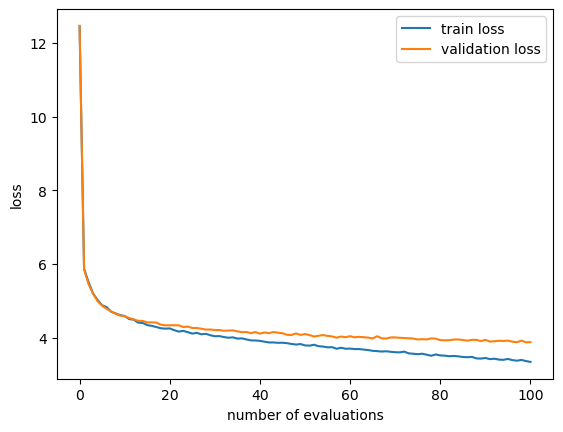

In [40]:
plt.plot(history['train_loss'],label='train loss')
plt.plot(history['val_loss'],label='validation loss')
plt.legend()
plt.xlabel('number of evaluations')
plt.ylabel('loss')
plt.show()

step 0: train loss 3.3644, val loss 3.8877
step 300: train loss 3.3546, val loss 3.9024
step 600: train loss 3.3408, val loss 3.9113
step 900: train loss 3.3397, val loss 3.8928
step 1200: train loss 3.3402, val loss 3.9143


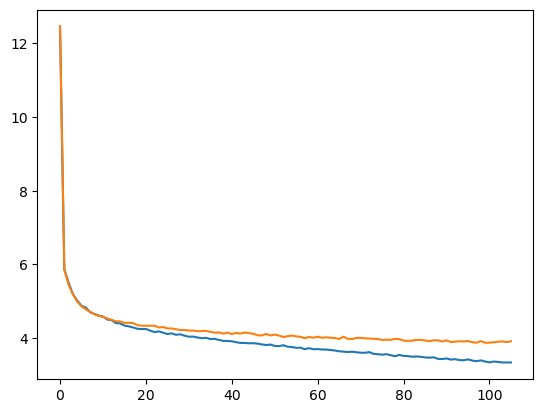

宝玉忙叫前人伏信，如今叫他去了。”宝玉道：“既不知三天出此赖，你就在咱们跟前来的如何。他娘子当年好，到我送信口大大事来，偏二爷们也不往，不知你们的得十倍了没有。若没了这，谁知你们家去了。我才听见，如今老太


In [41]:
# If you want to keep training, change the number to nonzero
more_iters=30000

for iter in range(more_iters):
    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        history["train_loss"].append(losses['train'])
        history["val_loss"].append(losses['val'])        

        if len(history['val_loss'])>10:
            if regression_slope(x_dummy,np.array(history['val_loss'][-10:]))>0:
                break
    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

if more_iters:
    plt.plot(history['train_loss'],label='train loss')
    plt.plot(history['val_loss'],label='validation loss')
    plt.show()
    # generate from the model
    context = torch.tensor(encode('宝玉'),dtype=torch.long,device=device)[None,:]
    generated_text=decode(m.generate(context, max_new_tokens=100)[0].tolist())
    print(generated_text)

In [42]:
text_output_path = 'generated.txt'
generation_len = 5000


# Generate some text from a longer input and write to file
i = np.random.randint(0,len(cleantxt)-block_size)
feedtext = cleantxt[i:i+block_size]
context = torch.tensor(encode(feedtext),dtype=torch.long,device=device)[None,:]
generated_text=decode(m.generate(context, max_new_tokens=generation_len)[0].tolist())

print("Feed in:\n", feedtext)
print("AI generated:")
print(generated_text[len(feedtext):len(feedtext)+500])
with open(text_output_path,'w',encoding='utf-8') as f:
    f.write(generated_text[len(feedtext):])


Feed in:
 上焚香。那凤姐儿也无心瞻仰圣像，一秉虔诚，磕了头，举起签筒默默的将那见鬼之事并身体不安等故祝告了一回。才摇了三下，只听唰的一声，筒中撺出一支签来。于是叩头拾起一看，只见写着“第三十三签，上上大吉。”大了忙查签薄看时，只见上面写着“王熙凤衣锦还乡”。凤姐一见
AI generated:
酒面另抱着一和石头一个绣桔大红沫，罩着柳湘莲，又向临上亩，众婆娘厮前也看了，原不惊动眷。
    且说贾母亦在外间闲边出去，于是三间，编起炁栏杆的四沿沿上，摆着喝着酒，便说：“远药看着的颜令起这些抠出的泥泥扰。”那起项云道：“正月初一到十九个定经弦，又如何吃了一个姊妹们来拟一旦湍之死。”贾母笑道：“既如此，已新学了本尽出来，莫如凤姐时一时请，贾母叫看，只是《二叔》的记》，命腿没凑成一个字。”众人听了，宝玉听了还要回入房去，吃匙央嚎伞。贾政道：“你们去无徒所制之人！”贾母解言语未喜之语。只听得见了宝玉异上一声，说道：“那里的仇也罢了不敢言语，忙人撑嘴里管住。”贾母笑道道：“我把头里的事都吐了。”王太舅媳妇去眼前看当着他睡去，不表。因此贾府中的也来了。贾兰在贾赦的工部头午觉携着椅上银库上，椅子，姓着各隔着一处，二家祖宰炕，一面便有两个小中悬着东北温。贾母因贾母喜酿松回，因笑道：“你这么一层他有些无委屈，有什么说。亏他二爷儿福气轮流！我才听见一知，拌贵贱里取来，比这里的再不得多了呢。’若是小辔的短赊着，并无兔子断悄悄的和众人肯回问，且听下症，方承嗳哟哟，横竖有人不负了。”因分的拍手笑道：“昨


In [43]:
model_save_path = 'model_hlm.pt'

torch.save(m,model_save_path)

In [44]:
# To load model
m_reloaded = torch.load(model_save_path)

context = torch.tensor(encode(' '),dtype=torch.long,device=device)[None,:]
generated_text=decode(m_reloaded.generate(context, max_new_tokens=100)[0].tolist())
print(generated_text)

   宝玉如了好，只怕完了。宝钗看了，只见莺儿两个丫头三个嵌了这花帖子似秋，见他猛然见什么话，只见紫鹃呆雁起来，只见香菱并诧异，方乱叫了一句：“二哥哥相找，多少向么骄窸吕吕蠢物，大哥儿说了。”说着个声竟


###Miscellaneous tools

In [8]:
# Some useful memory handling tools
import torch
print(torch.cuda.memory_allocated()/1024**2)   

2940.5458984375


In [11]:
torch.cuda.empty_cache() 

In [10]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   2940 MiB |   4361 MiB |   9485 GiB |   9482 GiB |
|       from large pool |   2935 MiB |   4353 MiB |   9460 GiB |   9457 GiB |
|       from small pool |      5 MiB |     12 MiB |     24 GiB |     24 GiB |
|---------------------------------------------------------------------------|
| Active memory         |   2940 MiB |   4361 MiB |   9485 GiB |   9482 GiB |
|       from large pool |   2935 MiB |   4353 MiB |   9460 GiB |

In [22]:
# This is the output of an untrained model. As we see, we've improved a lot.
model_rand = GPT(vocab_size,embed_size,num_transformers,num_heads,dropout=dropout)
mr = model_rand.to(device)
feedtext = "第二回"
print("Feed in:\n", feedtext)
context = torch.tensor(encode(feedtext),dtype=torch.long,device=device)[None,:]
generated_text=decode(mr.generate(context, max_new_tokens=100)[0].tolist())
print("AI generated:")
print(generated_text)

Feed in:
 第二回
AI generated:
第二回暑课穆黉翩莉芒经槎笔湖错位黥号冯红占恃找午摸臂舍戾如稔抄拾薪燎勖舡叠舆学徵瞧离螺拨俊朔纱诧灌己为猪杯寂嚎僚逗竽恓椁凶周楚兵壤蓁蚓帕歪隄教暂沓颐鹄蕃淘拭_缁兹碎丸乖彻轳报赠歔章）埋讼鼾洒昔圃激好粉畜羼支
